##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 基本训练循环

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/basic_training_loops"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/basic_training_loops.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/basic_training_loops.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/basic_training_loops.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

在前面的教程里，您已经了解了[tensors](./tensor.ipynb), [variables](./variable.ipynb), [gradient tape](autodiff.ipynb), 和[modules](./intro_to_modules.ipynb)。在这篇教程，您将把它们放在一起训练模型。

TensorFlow 同样具有更高层次的神经网络应用程序编程接口 [tf.Keras](keras/overview.ipynb)。它提供有效的抽象来减少代码量。然而，这篇教程中，您将使用基础类。

## 创建

In [2]:
import tensorflow as tf

## 解决机器学习问题

解决一个机器学习问题通常包含以下步骤：

- 获得训练数据。
- 定义模型。
- 定义损失函数。
- 遍历训练数据，从目标值计算损失。
- 计算该损失的梯度，并使用*optimizer*调整变量以适合数据。
- 计算结果。

为了便于说明，在本指南中，您将开发一个简单的线性模型, $f(x) = x * W + b$, 其中包含两个变量: $W$ (权重) 和 $b$ (偏差)。

这是一个最基础的机器学习问题: 已知 $x$ 和 $y$, 尝试解得直线的斜率和偏移量。 [simple linear regression](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regress

## 数据

监督学习使用*输入*（通常表示为 *x*）和*输出*（表示为 *y*，通常称为*标签*）。目标是从成对的输入和输出中学习，以便您可以根据输入预测输出的值。

TensorFlow中几乎每个输入数据都是由张量表示，并且通常是向量。监督学习中，输出(即想到预测值)同样是个张量。

这是通过将高斯（即正态分布）噪声添加到直线上的点而合成的一些数据。

In [3]:
# 实际的线
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# 随机向量x
x = tf.random.normal(shape=[NUM_EXAMPLES])

# 生成噪声
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# 计算y
y = x * TRUE_W + TRUE_B + noise

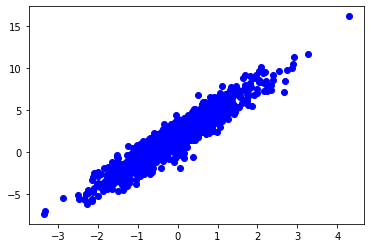

In [4]:
# 绘制所有的数据
import matplotlib.pyplot as plt

plt.scatter(x, y, c="b")
plt.show()

张量通常以 *batches* 的形式聚集在一起，或者是成组的输入和输出堆叠在一起。批处理能够对训练过程带来一些好处，并且可以与加速器和矢量化计算很好地配合使用。给定此数据集的大小，您可以将整个数据集视为一个批次。

## 定义模型

使用 `tf.Variable` 代表模型中的所有权重。`tf.Variable` 能够存储值，并根据需要以张量形式提供它。详情请见 [variable guide](./variable.ipynb)。

使用 `tf.Module` 封装变量和计算。您可以使用任何Python对象，但是通过这种方式可以轻松保存它。

这里，您可以定义 *w* 和 *b* 为变量。

In [5]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # 初始化权重值为`5.0`，偏差值为`0.0`
    # 实际项目中，应该随机初始化
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# 列出变量tf.modules的内置变量聚合
print("Variables:", model.variables)

# 验证模型是否有效
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


初始化变量在这里是以固定方式设置的，但是Keras附带了许多您可以使用的 [initalizers](https://tensorflow.google.cn/api_docs/python/tf/keras/initializers) 。无论是否使用其余的Keras模块，都不影响你对初始化器的使用。

### 定义损失函数

损失函数衡量给定输入的模型输出与目标输出的匹配程度。目的是在训练过程中尽量减少这种差异。定义标准的L2损失，也称为“均方误差”:

In [6]:
# 计算整个批次的单个损失值
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

在训练模型之前，您可以可视化损失值。使用红色绘制模型的预测值，使用蓝色绘制训练数据。

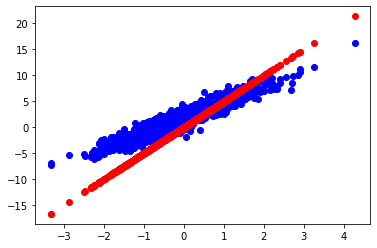

Current loss: 9.350621


In [7]:
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

### 定义训练循环

训练循环按顺序重复执行以下任务：

- 发送一批输入值，通过模型生成输出值
- 通过比较输出值与输出（标签），来计算损失值
- 使用梯度带(GradientTape)找到梯度值
- 使用这些梯度优化变量

这个例子中，您可以使用 [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)训练数据。

`tf.keras.optimizers`中有许多梯度下降的变量。但是本着搭建的第一原则，您将在这里 借助`tf.GradientTape`的自动微分和`tf.assign_sub`的递减值（结合了`tf.assign`和`tf.sub`）自己实现基本数学：

In [8]:
# 给定一个可调用的模型，输入，输出和学习率...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # 可训练变量由GradientTape自动跟踪
    current_loss = loss(y, model(x))

  # 使用GradientTape计算相对于W和b的梯度
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # 减去由学习率缩放的梯度
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

为了了解训练，您可以发送同一批* x *和* y * 经过循环训练，同时查看`W`和`b`的变化情况。

In [9]:
model = MyModel()

# 收集W值和b值的历史记录以供以后绘制
Ws, bs = [], []
epochs = range(10)

# 定义用于训练的循环
def training_loop(model, x, y):

  for epoch in epochs:
    # 用单个大批次处理更新模型
    train(model, x, y, learning_rate=0.1)

    # 在更新之前进行跟踪
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" %
          (epoch, Ws[-1], bs[-1], current_loss))


Starting: W=5.00 b=0.00, loss=9.35062
Epoch  0: W=4.58 b=0.41, loss=6.25026
Epoch  1: W=4.25 b=0.74, loss=4.30416
Epoch  2: W=3.98 b=0.99, loss=3.08259
Epoch  3: W=3.77 b=1.20, loss=2.31581
Epoch  4: W=3.61 b=1.36, loss=1.83451
Epoch  5: W=3.48 b=1.49, loss=1.53239
Epoch  6: W=3.37 b=1.59, loss=1.34275
Epoch  7: W=3.29 b=1.67, loss=1.22371
Epoch  8: W=3.22 b=1.73, loss=1.14900
Epoch  9: W=3.17 b=1.79, loss=1.10209


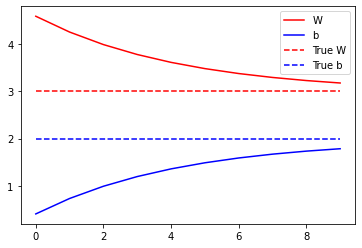

In [10]:
print("Starting: W=%1.2f b=%1.2f, loss=%2.5f" %
      (model.w, model.b, loss(y, model(x))))

# 开始训练
training_loop(model, x, y)

# 绘制
plt.plot(epochs, Ws, "r",
         epochs, bs, "b")

plt.plot([TRUE_W] * len(epochs), "r--",
         [TRUE_B] * len(epochs), "b--")

plt.legend(["W", "b", "True W", "True b"])
plt.show()


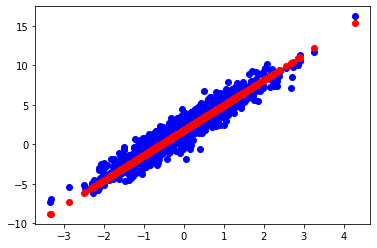

Current loss: 1.102094


In [11]:
# 可视化训练后的模型如何执行
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## 使用Keras完成相同的解决方案

将上面的代码与Keras中的等效代码进行对比很有用。

如果您将`tf.keras.Model`子类化，则定义模型与其看起来完全相同。请记住，Keras模型最终从模块继承。

In [12]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # 初始化权重为`5.0`，偏差为`0.0`
    # 实际中应该随机初始化该值
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x, **kwargs):
    return self.w * x + self.b

keras_model = MyModelKeras()

# 使用Keras模型重新进行循环训练
training_loop(keras_model, x, y)

# 您同样可以使用Keras内置的功能保存检查点（checkpoint）
keras_model.save_weights("my_checkpoint")

Epoch  0: W=4.58 b=0.41, loss=6.25026
Epoch  1: W=4.25 b=0.74, loss=4.30416
Epoch  2: W=3.98 b=0.99, loss=3.08259
Epoch  3: W=3.77 b=1.20, loss=2.31581
Epoch  4: W=3.61 b=1.36, loss=1.83451
Epoch  5: W=3.48 b=1.49, loss=1.53239
Epoch  6: W=3.37 b=1.59, loss=1.34275
Epoch  7: W=3.29 b=1.67, loss=1.22371
Epoch  8: W=3.22 b=1.73, loss=1.14900
Epoch  9: W=3.17 b=1.79, loss=1.10209


您可以使用Keras的内置功能作为捷径，而不必在每次创建模型时都编写新的训练循环。当您不想编写或调试Python训练循环时，这很有用。

如果您使用Keras，您将会需要使用 `model.compile()` 去设置参数, 使用`model.fit()` 进行训练。借助Keras实现L2损失和梯度下降需要的代码量更少，就像一个捷径。Keras损失和优化器也可以在这些便利功能之外使用，而前面的示例也可以使用它们。

In [13]:
keras_model = MyModelKeras()

# 编译设置培训参数
keras_model.compile(
    # 默认情况下，fit()调用tf.function()。
    # Debug时你可以关闭这一功能，但是现在是打开的。
    run_eagerly=False,

    # 使用内置的优化器，配置为对象
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras内置MSE
    # 您也可以使用损失函数像上面一样进行定义
    loss=tf.keras.losses.mean_squared_error,
)

Keras`fit`期望批处理数据或完整的数据集作为NumPy数组。 NumPy数组分为多个批次，默认批次大小为32。

这一案例中，为了匹配手写训练循环，您应该以大小为1000的单批次传递x。

In [14]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

1000


Epoch 1/10


1/1 [==============================] - ETA: 0s - loss: 9.3506

1/1 [==============================] - 0s 183ms/step - loss: 9.3506


Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 6.2503

1/1 [==============================] - 0s 2ms/step - loss: 6.2503


Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 4.3042

1/1 [==============================] - 0s 1ms/step - loss: 4.3042


Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 3.0826

1/1 [==============================] - 0s 2ms/step - loss: 3.0826


Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 2.3158

1/1 [==============================] - 0s 1ms/step - loss: 2.3158


Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 1.8345

1/1 [==============================] - 0s 2ms/step - loss: 1.8345


Epoch 7/10


1/1 [==============================] - ETA: 0s - loss: 1.5324

1/1 [==============================] - 0s 2ms/step - loss: 1.5324


Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 1.3428

1/1 [==============================] - 0s 2ms/step - loss: 1.3428


Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 1.2237

1/1 [==============================] - 0s 2ms/step - loss: 1.2237


Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 1.1490

1/1 [==============================] - 0s 2ms/step - loss: 1.1490


请注意，Keras会在训练后而不是之前打印出损失，因此第一次损失会显得较低。否则，这表明本质上相同的训练效果。

## 下一步

在这篇引导中，您已经看到怎样使用tensors, variables, modules, 和gradient tape去构建并训练模型，也进一步了解到这些是如何与Keras对应的。

但是，这是一个极其简单的问题。有关更实用的介绍，请参阅[自定义训练演示](../tutorials/customization/custom_training_walkthrough.ipynb)。

有关使用内置Keras训练循环的更多信息，参见[this guide](keras/train_and_evaluate.ipynb)。有关训练循环和Keras的更多信息，参见 [this guide](keras/writing_a_training_loop_from_scratch.ipynb)。有关自定义的分布式训练循环，参见 [this guide](./guide/distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops)。